<a href="https://colab.research.google.com/github/prathamc25/whisper-speculative-decoding/blob/main/notebook_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet torch transformers accelerate evaluate jiwer
!pip install datasets[audio]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 36.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.9.0+cu126 requires torch==2.9.0, but you have torch 2.9.1 which is incompatible.
torchvision 0.24.0+cu126 requires torch==2.9.0, but you have torch 2.9.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.9 MB/s  0:00:00


In [ ]:
import torch
import time
import librosa
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Union, Optional
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor
from datasets import load_dataset
import evaluate

class SpeculativeWhisper:
    def __init__(self,
                 model_id: str = "openai/whisper-large-v2",
                 draft_model_id: Optional[str] = None,
                 device: Optional[str] = None,
                 torch_dtype: Optional[torch.dtype] = None):

        self.device = device if device else ("cuda" if torch.cuda.is_available() else "cpu")
        self.dtype = torch_dtype if torch_dtype else (torch.float16 if self.device == "cuda" else torch.float32)

        print(f"   [Init] Loading Main: {model_id}...")
        self.main_model = AutoModelForSpeechSeq2Seq.from_pretrained(
            model_id,
            torch_dtype=self.dtype,
            low_cpu_mem_usage=True,
            use_safetensors=True,
            attn_implementation="sdpa",
        ).to(self.device)

        self.draft_model = None
        if draft_model_id:
            print(f"   [Init] Loading Draft: {draft_model_id}...")
            self.draft_model = AutoModelForSpeechSeq2Seq.from_pretrained(
                draft_model_id,
                torch_dtype=self.dtype,
                low_cpu_mem_usage=True,
                use_safetensors=True,
                attn_implementation="sdpa",
            ).to(self.device)

        self.processor = AutoProcessor.from_pretrained(model_id)

    def _load_audio(self, audio_paths: Union[List[str], List[np.ndarray]]) -> List[np.ndarray]:
        audio_arrays = []
        for audio in audio_paths:
            if isinstance(audio, str):
                array, _ = librosa.load(audio, sr=16000)
                audio_arrays.append(array)
            elif isinstance(audio, np.ndarray):
                audio_arrays.append(audio)
            else:
                raise ValueError("Audio must be a file path or numpy array.")
        return audio_arrays

    def transcribe(self,
                   audio_inputs: Union[List[str], List[np.ndarray]],
                   batch_size: int = 1,
                   use_speculative: bool = True,
                   language: str = "en",
                   task: str = "transcribe",
                   **generate_kwargs):

        # Safety Check: Beam Search prevents Speculative Decoding
        if generate_kwargs.get("num_beams", 1) > 1 and use_speculative:
            use_speculative = False

        raw_audio = self._load_audio(audio_inputs)
        transcriptions = []
        total_inference_time = 0

        for i in range(0, len(raw_audio), batch_size):
            batch_audio = raw_audio[i : i + batch_size]

            inputs = self.processor(
                batch_audio,
                sampling_rate=16000,
                return_tensors="pt",
                padding="max_length",
                truncation=True
            )
            input_features = inputs.input_features.to(self.device, dtype=self.dtype)

            gen_args = {
                "input_features": input_features,
                "max_new_tokens": 400, # Limit to avoid 448 error
                "language": language,
                "task": task,
                **generate_kwargs
            }

            # Only use assistant if requested AND model exists
            if use_speculative and self.draft_model:
                gen_args["assistant_model"] = self.draft_model

            if self.device == "cuda": torch.cuda.synchronize()
            start_time = time.time()

            with torch.no_grad():
                generated_ids = self.main_model.generate(**gen_args)

            if self.device == "cuda": torch.cuda.synchronize()
            total_inference_time += (time.time() - start_time)

            batch_transcripts = self.processor.batch_decode(generated_ids, skip_special_tokens=True)
            transcriptions.extend(batch_transcripts)

        return transcriptions, total_inference_time

# Helper plotting function
def plot_dashboard(results, title_suffix=""):
    df = pd.DataFrame(results)
    # Use first result (Baseline) for speedup calc
    baseline = df.iloc[0]["latency"]
    df["speedup"] = baseline / df["latency"]

    sns.set_theme(style="whitegrid")
    fig = plt.figure(figsize=(14, 8))
    gs = fig.add_gridspec(2, 1, height_ratios=[1, 1.2])

    # Plot 1: Latency
    ax1 = fig.add_subplot(gs[0])
    bars = ax1.barh(df["config"], df["latency"], color=df["color"], alpha=0.9)
    ax1.set_title(f"Inference Latency {title_suffix} (Lower is Better)", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Latency (seconds)", fontsize=11)
    ax1.invert_yaxis()
    for bar in bars:
        ax1.text(bar.get_width()+0.05, bar.get_y()+bar.get_height()/2, f'{bar.get_width():.2f}s', va='center')

    # Plot 2: WER vs Speed
    ax2 = fig.add_subplot(gs[1])
    sns.scatterplot(data=df, x="latency", y="wer", s=300, hue="config", palette=dict(zip(df["config"], df["color"])), legend=False, ax=ax2, edgecolor="black")
    for i, row in df.iterrows():
        ax2.text(row["latency"], row["wer"] + (max(df["wer"])*0.01), row["config"].split('\n')[0], ha='center', fontsize=10)
    ax2.set_title("Efficiency: Accuracy vs Speed", fontsize=14, fontweight='bold')
    ax2.set_xlabel("Latency (s) ->", fontsize=11)
    ax2.set_ylabel("WER ->", fontsize=11)

    plt.tight_layout()
    plt.show()

Loading 8 samples from LibriSpeech...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/48 [00:00<?, ?it/s]


=== STARTING SPECULATIVE BENCHMARK ===

 Running Config: Baseline (Large-V2)
   [Init] Loading Main: openai/whisper-large-v2...


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/6.17G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



 Running Config: Draft: Tiny
   [Init] Loading Main: openai/whisper-large-v2...
   [Init] Loading Draft: openai/whisper-tiny...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/151M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]


 Running Config: Draft: Base
   [Init] Loading Main: openai/whisper-large-v2...
   [Init] Loading Draft: openai/whisper-base...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/290M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]


 Running Config: Draft: Distil-Large
   [Init] Loading Main: openai/whisper-large-v2...
   [Init] Loading Draft: distil-whisper/distil-large-v2...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.51G [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]


=== SPECULATIVE RESULTS ===
                config   latency  wer
0  Baseline (Large-V2)  8.049762  1.0
1          Draft: Tiny  4.193596  1.0
2          Draft: Base  4.623690  1.0
3  Draft: Distil-Large  5.920076  1.0


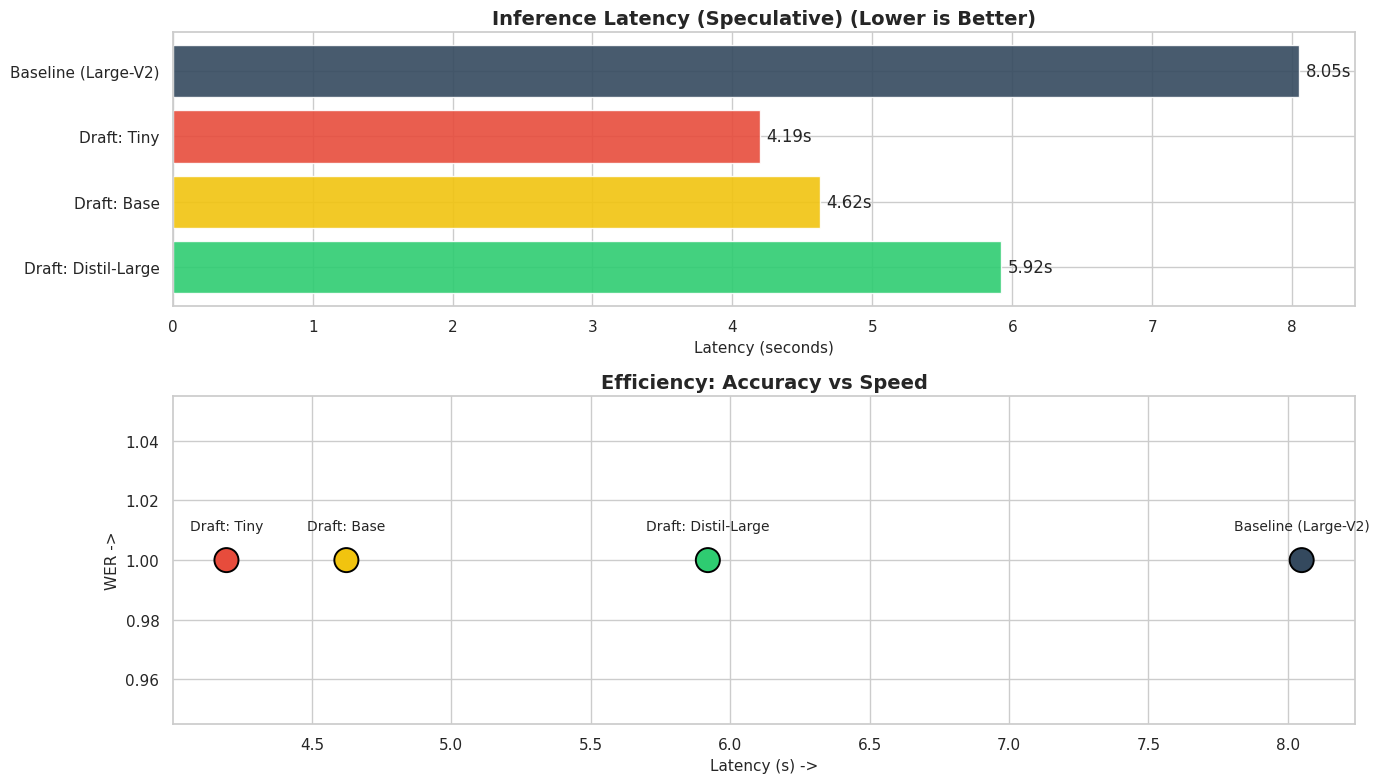

In [ ]:
# --- CONFIGURATION ---
NUM_SAMPLES = 8
SPECULATIVE_CONFIGS = [
    {"name": "Baseline (Large-V2)", "main": "openai/whisper-large-v2", "draft": None, "color": "#34495e"},
    {"name": "Draft: Tiny", "main": "openai/whisper-large-v2", "draft": "openai/whisper-tiny", "color": "#e74c3c"},
    {"name": "Draft: Base", "main": "openai/whisper-large-v2", "draft": "openai/whisper-base", "color": "#f1c40f"},
    {"name": "Draft: Distil-Large", "main": "openai/whisper-large-v2", "draft": "distil-whisper/distil-large-v2", "color": "#2ecc71"}
]

# 1. Load Data
print(f"Loading {NUM_SAMPLES} samples from LibriSpeech...")
dataset = load_dataset("librispeech_asr", "clean", split="validation", streaming=True)
samples = list(dataset.take(NUM_SAMPLES))
audio_inputs = [x["audio"]["array"] for x in samples]
references = [x["text"] for x in samples]
wer_metric = evaluate.load("wer")

results_spec = []

# 2. Run Benchmark Loop
print("\n=== STARTING SPECULATIVE BENCHMARK ===")
for cfg in SPECULATIVE_CONFIGS:
    print(f"\n Running Config: {cfg['name']}")

    # Init Class (Garbage collection ensures we don't run out of VRAM)
    sw = SpeculativeWhisper(model_id=cfg["main"], draft_model_id=cfg["draft"])

    # Run Transcribe
    # use_speculative=True only works if draft_model was provided in __init__
    preds, duration = sw.transcribe(
        audio_inputs,
        batch_size=1,
        use_speculative=True if cfg["draft"] else False
    )

    # Compute Metrics
    wer = wer_metric.compute(predictions=preds, references=references)
    results_spec.append({
        "config": cfg["name"], "latency": duration, "wer": wer, "color": cfg["color"]
    })

    # Cleanup
    del sw
    gc.collect()
    torch.cuda.empty_cache()

# 3. Show Results
print("\n=== SPECULATIVE RESULTS ===")
print(pd.DataFrame(results_spec)[["config", "latency", "wer"]])
plot_dashboard(results_spec, title_suffix="(Speculative)")


=== STARTING BEAM SEARCH BENCHMARK ===

 Running Beam Search: Tiny (Beam 5)
   [Init] Loading Main: openai/whisper-tiny...


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]


 Running Beam Search: Base (Beam 5)
   [Init] Loading Main: openai/whisper-base...


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]


 Running Beam Search: Large-V2 (Beam 5)
   [Init] Loading Main: openai/whisper-large-v2...

=== BEAM SEARCH RESULTS ===
              config    latency       wer
0      Tiny (Beam 5)   1.593915  1.015873
1      Base (Beam 5)   1.770726  1.007937
2  Large-V2 (Beam 5)  14.780168  1.000000


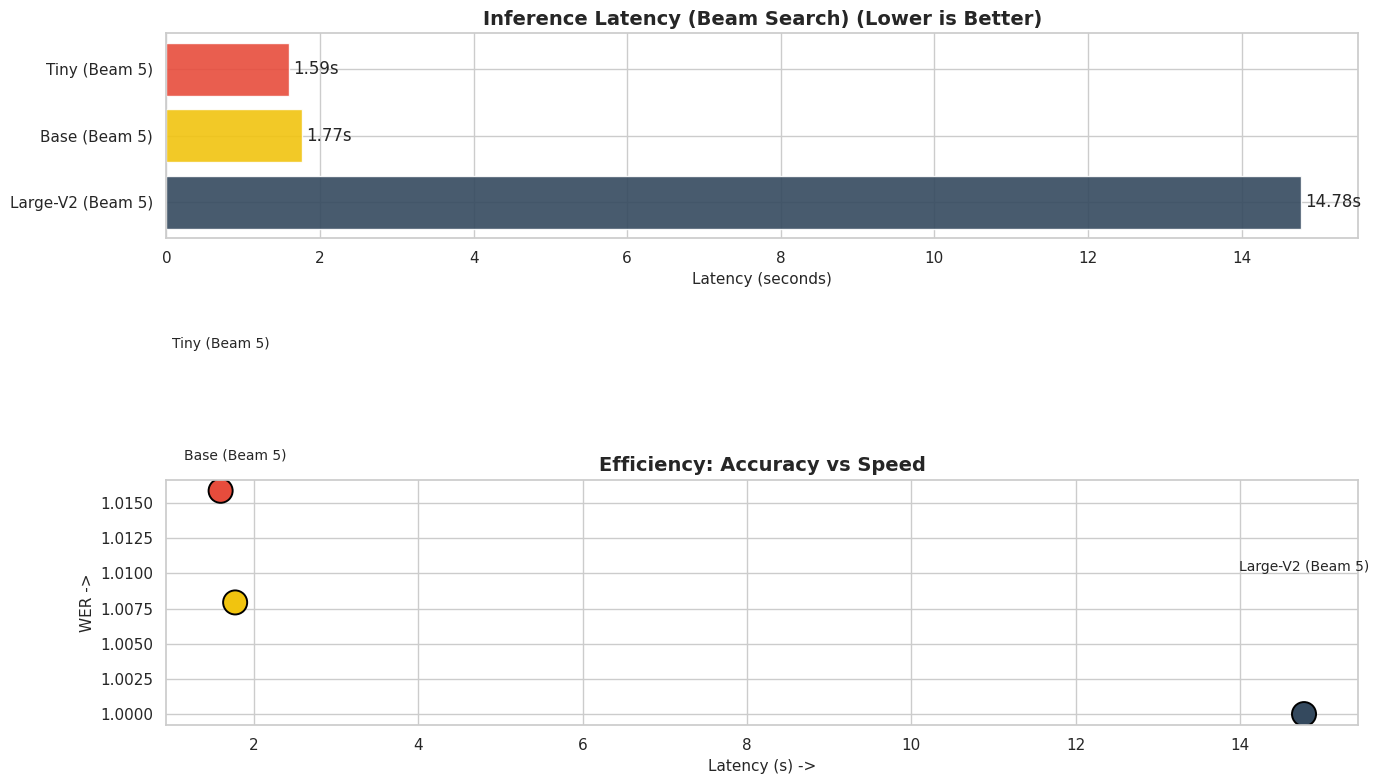

In [ ]:
# --- CONFIGURATION ---
BEAM_CONFIGS = [
    {"name": "Tiny (Beam 5)", "main": "openai/whisper-tiny", "color": "#e74c3c"},
    {"name": "Base (Beam 5)", "main": "openai/whisper-base", "color": "#f1c40f"},
    {"name": "Large-V2 (Beam 5)", "main": "openai/whisper-large-v2", "color": "#34495e"},
]

results_beam = []

# 1. Run Benchmark Loop
print("\n=== STARTING BEAM SEARCH BENCHMARK ===")
for cfg in BEAM_CONFIGS:
    print(f"\n Running Beam Search: {cfg['name']}")

    # Init Class (No draft model needed for pure Beam Search)
    sw = SpeculativeWhisper(model_id=cfg["main"], draft_model_id=None)

    # Run Transcribe with Beam Search
    preds, duration = sw.transcribe(
        audio_inputs,
        batch_size=1,
        use_speculative=False, # Explicitly disabled
        num_beams=5            # Enable Beam Search
    )

    # Compute Metrics
    wer = wer_metric.compute(predictions=preds, references=references)
    results_beam.append({
        "config": cfg["name"], "latency": duration, "wer": wer, "color": cfg["color"]
    })

    # Cleanup
    del sw
    gc.collect()
    torch.cuda.empty_cache()

# 2. Show Results
print("\n=== BEAM SEARCH RESULTS ===")
print(pd.DataFrame(results_beam)[["config", "latency", "wer"]])
plot_dashboard(results_beam, title_suffix="(Beam Search)")